# Satellite time-series crop classification and clustering
## Tutorial 1: Rasterizing vector data and time-series clustering

This is the first in a two-part turorial providing working examples the classes and functions avaliable in the `satTS` (satellite time-series) python library.  

**Motivation:** The exponential increase in high temporal and spatial resolution satellite and other earth observation (EO) data in the past ~5 years, and simlutaneous improvements in geospatial data storage, processing, and analysis capabilities, represents a unique opportunity to derive signals and insights about our planet that were previously impossible or prohibitively resource intensive. However, many of the most successful machine learning algorithms (e.g. convolutional neural networks) do not perform well when predicting certain land use / land cover (LULC) classes using satellite images. This is especially true when trying to classify LULC that is not easily identifiable by eye, e.g., individual crop types in small fields common to developing countries. The challenge is greater when it becomes necessary to incorporate a time-series of images in order to achieve high classification accuracy, e.g. to capture the change in crop phenology over the growing season. In view of these challenges, the primary motivation for `satTS` was to build tools that allow for the easy handling and analysis of EO time-series data. 

**Problem:** The focus of these tutorials is a crop classification problem in southern Tanzania. Crop-type classification in developing countries using satellite data presents several unique challenges which serve to highlight the functionality of `satTS`. First, plot sizes typicaly are small, limiting the effectiveness of low-resolution satellite images. Second, field-collected, georeferenced/timestaped ground-truth training data are generally limited for key regions of interest. Third, because of the similarity in the refelctance values (data stored in satellite bands) of different crops at any given date, it is usually insufficient to use a static image from a single date to distinguish individual crops. 

We've chosen Sentinel-2 satellite imagery for this problem, due to it's relatively high spatial resolution (10 m for most bands) and revisit rate (5 days in most regions). Sentinel-2 imagery is publically available and contains unique bands useful for monitoring vegetation health and productivity. The problem is broken down in to two distinct phases, whith a focus on classifying maize, due to its sizeable share of smallholder agricultural output in the region:

1. Rasterizing vector data generated in a GIS software to generate "ground-truth" polygons corresponsing to LULC classes, generating NDVI time-series' of individual pixels within the labeled polygons, and clustering the resulting time-series' using an unserpvised machine learning algorithm; and



2. Labeling the resulting clusters as maize and "other" crop types based on patterns in their NDVI curves through the growing season. The idea is that, given a known cropping calendar for the region, and some additional domain-knowledge about growth characteristics of maize, it may be possible to label one or more clusters as maize, thereby generating a "synthetic" or "semi-synthetic" training dataset to be used to train a supervised classifier. 

This tutorial focuses on **phase 1** of the process 1) rasterizing a shapefile of comprising land cover polygons to create a training data set of NDVI time-series' values for individual pixels, and 2) using unsupervised learning to cluster resulting NDVI time-series belonging to the "cropped" LULC class. 

Please feel free to investigate the satTS source code, comment, etc. [here](https://github.com/developmentseed/satTS). This library is still very much a work in progress.



## Step 1 - Rasterize shapefile containing ground-truth polygons 

Fitting supervised statistical models using EO data requires "ground-truth" labels corresponsing to known locations of the classes of objects or land cover to be predicted. With high-resolution satellite images, it is possible to generate ground-truth labels of certain LULC classes by drawing polygons, lines, or points directly on the image. Whether Sentinel-2 images can be considered "high-resolution" is debatable, but certain LULC classes are nevertheless easily identifiable from the true-color, RGB image as shown below:

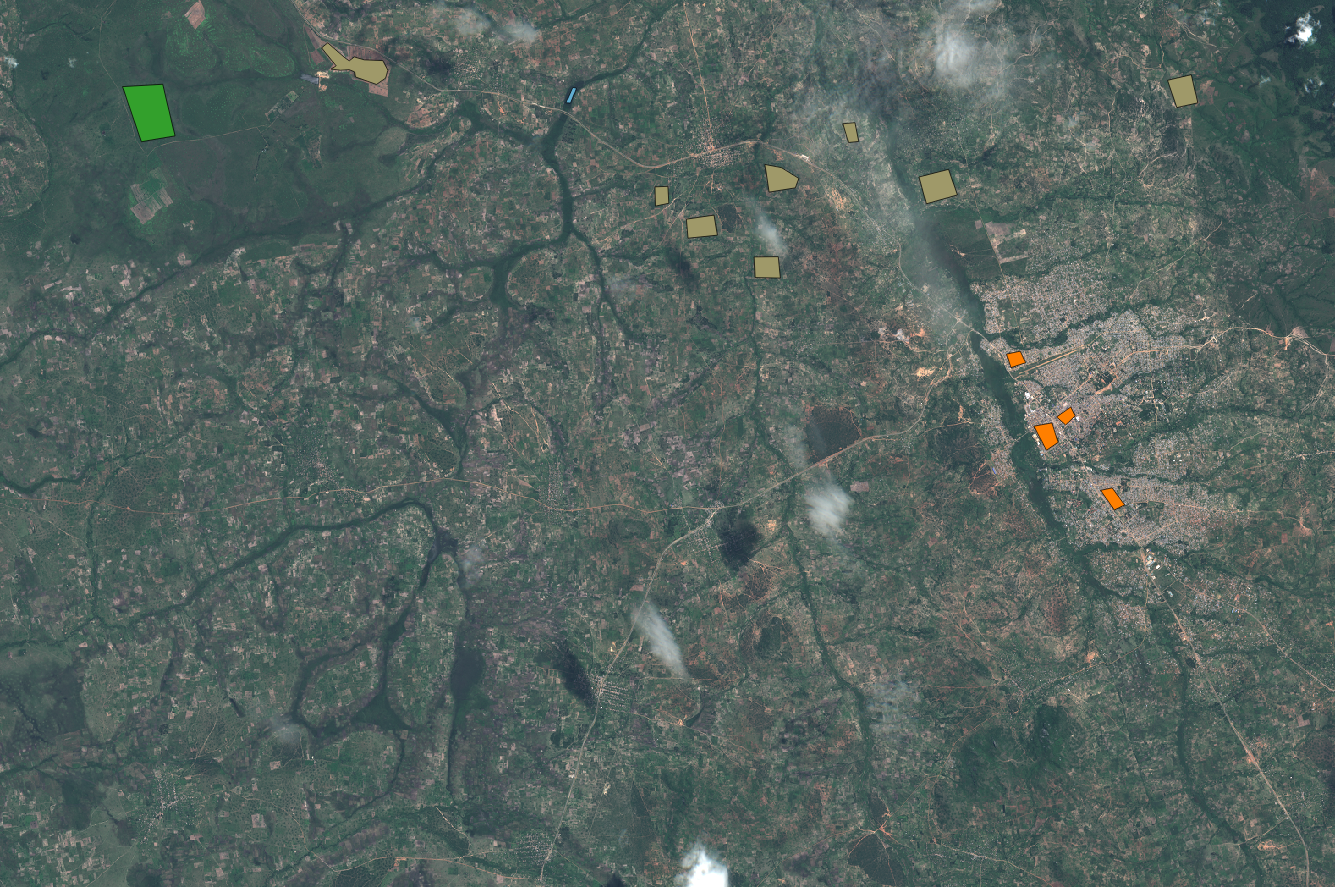

The image above, showing a small area of Rukwa Region, Tanzania, was created in GQIS. Orange polygons corresponds to urban area, blue to water, yellow to cropped (agricultural) area, and green to vegetation (non-agricultural). For the ull training dataset, polygons for each of the LULC categories were generated across the full Sentinel-2 tile. 

In order to extract the reflectance values for each pixel within the labeled classes, we need to first "rasterize" these vector data, essentially creating a new image band of the same shape and resolution as the Sentinel-2 scene used to generate the ground-truth polygons. Pixels that intersect with a polygon will be given that classes label, and all other unlabeled pixels will be given a no-data value. 

First, we'll load the various modules required to complete this task:

In [3]:
# Load satTS libraries 
from satts import tsmask
from satts import tsclust
from satts import tstrain

# Load helper libraries
from os import listdir
import re
import numpy as np
import pandas as pd
import pickle
import gippy # for reading, writing, and performing calculations on multi-spectral EO data

# Load plotting libraries
import matplotlib.pyplot as plt
from matplotlib import patches, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.


The `rasterize` function in `satts.tsmask` wraps GDAL's python bindings, taking advantage of `gdal.RasterizeLayer`, and takes 4 arguments: 

1. a file path pointing to vector data (either in geojson or shapefile format) to be rasterized, 


2. a "reference" image (in our case, the same image used to generate the ground-truth polygons shown above) providing the spatial and other metatdata (e.g. resolution, bounding box, coordinate reference system, etc.), 


3. a file path for the newly generated image of rasterized ground-truth data, and


4. an attribute to be used to "burn-in" the values during rasterization. In this case, a single shapefile was generated in QGIS containing all LULC classes, with an attribute called `id` identifying the class of polygon

In [13]:
# File path to folder containing shapefile to be rasterized and referene image
fp = '/Users/jameysmith/Documents/satts-tutorials/data'

# File path to landcover shapefile to be rasterized
shp = fp + '/lc_polygons.shp'

# output file (rasterized land cover)
outimg = fp + '/lcrast.tif'

# Reference image (Sentinel-2 tile)
refimg = fp + '/2016-11-16_B04.jp2'

In [14]:
# Perform rasterization 
tsmask.rasterize(shapefile=shp, outimg=outimg, refimg=refimg, attribute='id')

`tsmask` also provides a helper function for quick confirmation that the vector data were correctly burned into the raster layer:

Class 0 contains 119845316 pixels
Class 1 contains 503143 pixels
Class 2 contains 122586 pixels
Class 3 contains 83403 pixels
Class 4 contains 5952 pixels


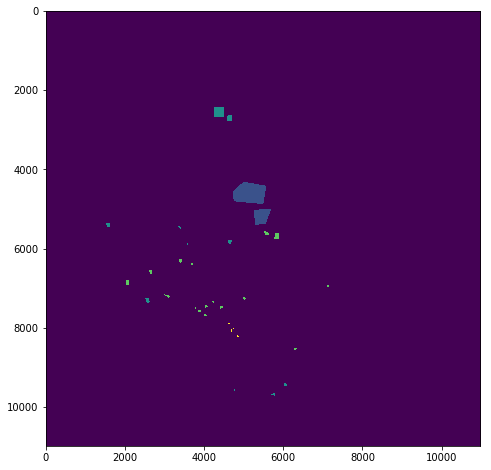

In [15]:
# Confirm land cover classes were burned into raster correctly
fig = plt.figure(figsize=(8, 8))
tsmask.check_rasterize(outimg, plot=True)

# 0 = nodata, 1 = water, 2 = veg, 3 = cropped, 4 = urban

## Step 2 - Find cloud-free(ish) Sentinel-2 images for the 2017 growing season

Because of the dynamic nature of crop appearance through a growing season, classifiers relying on an single image from a single date will have relatively low predictive power. To capture information about changes in the appearance of individual crops through a growing season, we'll incroporate features from a time-series of satelite images covering the 2017 growing season for the same tile in which the above polygons were drawn. We'll use the [sat-search](https://github.com/sat-utils/sat-search) command line tool for searching and downloading the image's that we're after. Sat-search can be downloaded with a pip install from the command line as follows: 

`pip install satsearch`

We'll look for images in the 2017 crop growing season for Southern Tanzania, running from November 2016, through December 2017. We want `sat-search` to return images with <15% cloud cover that intersect a GeoJSON bounding box around all of our training data polygons called `aoi.geojson`. The full command line query is shown below:

`sat-search search \
    -p c:id=sentinel-2-l1c \
    -p eo:platform=Sentinel-2A \
    --intersects aoi.geojson \
    --datetime 2016-11-01/2017-12-31 \
    --eo:cloud_cover 0/15 \
    --save scenes.json`


The above query saves the metadata associated with all Sentinel-2A scenes with <15% cloud cover between November 1, 2016 and December 31, 2017 in a file named “scenes.json.” The following command downloads the specified bands (assets) from their AWS S3 bucket locations to a local directory structure organized by date:

`sat-search load scenes.json --download B02 B03 B04 B08`

Bands 2, 3, 4, and 8 correspond to all 10 m resolution bands on Sentinel-2: blue, green, red, and NIR, respectively. This analysis did not incorporate SWIR or any of the Vegetation bands from Sentinel-2 due to the additional processing step required to match the their spatial resolution to the 10-m bands. The incorporation of these bands as additoinal model features should be explored in future analyses. 

Finally, we need to convert the JPEG 2000 files downloaded from S3 to GeoTIFFs. This step is not strictly necessary, but ensures driver compatability with certain raster read/write functionality used in the `satTS` library. This can be done from the command line with a simple bash script calling GDAL as follows (the following command assumes the default directory structure of the `sat-search load` command above):

`for i in *.jp2; do gdal_translate -of GTiff -co COMPRESS=LZW $i ${i/.jp2}.tif; done`

The JPEG 2000 files can then be removed from the same directory:

`find . -name "*.jp2" -exec rm -f {} \;`

After filtering to keep only those scenes in the 2017 growing season that had a cloud cover of under 15%, we were left with 28 scenes total. 

## Step 3 - Generate time-series of NDVI bands 

As a reminder, we are primarily interested in distinguishing different crop types within the "cropped" land cover class. Because we are not able identify individual crop types by eye, we need to rely on a signal contained within the band reflectance values themselves. 

The approach that follows relys on the fact that individual crops will have distinct patterns in "greeness" throughout the growing season based on factors such as planting and harvest date, and the inherent phenology of a given crop. As a measure of a pixel's greeness at a given point in time, we will employ the Normalized Difference Vegetation Index (NDVI) - an index created from values in the red and NIR bands of an image using the folowing formula: 

\begin{equation}
NDVI = \frac{NIR - RED}{NIR + RED}
\end{equation}

To generate an NDVI band for each image in the time-series, we can use `calculate_indices` from `tstrain`. The function takes a dictionary, `asset_dict` mapping the band numbers (stored in the GeoTIFF metadata) to their spectral region, and string, `scene_path`, specifying the path to the top level of the directory containing the files downloaded using `sat-search`, and a list, `indices`, of the indices to be calculated (see the `gippy` [documentation](https://gippy.readthedocs.io/en/latest/algorithms.html) for available indices). The function saves the new index bands to disk using the same file extension as the input files. 

Due to the computational load, we won't run the `tstrain.calculate_indices` here. The following demonstrates how one would use the function to calculate NDVI at each date in a time-series form a Sentinel-2 tile. 

In [16]:
# Band dictionary to match asset (band) names with variables
asset_dict = {'B02': 'blue',
              'B03': 'green',
              'B04': 'red',
              'B08': 'nir'}

scene_path = 'path/to/scenes'

In [17]:
# Create NDVI band for each date. Writes new band to disk as GeoTIFF
tstrain.calulate_indices(scene_path, asset_dict, indices=['ndvi'])

As an illustrative example, we can visualize the NDVI of our Sentinel-2 tile containing the training data polygons for a single date in the time series:

In [18]:
# Open NDVI values from the Sentinel-2 scene from April 4th, 2017
ndvi = fp + '/2017-04-05_ndvi.tif'
img = gippy.GeoImage.open(filenames=[ndvi], bandnames=['ndvi'], gain = 0.0001)

# Read NDVI band values into numpy array
ds = img.read()

In [19]:
# Deal with nodata values
ds[ds == -32768.0] = np.nan

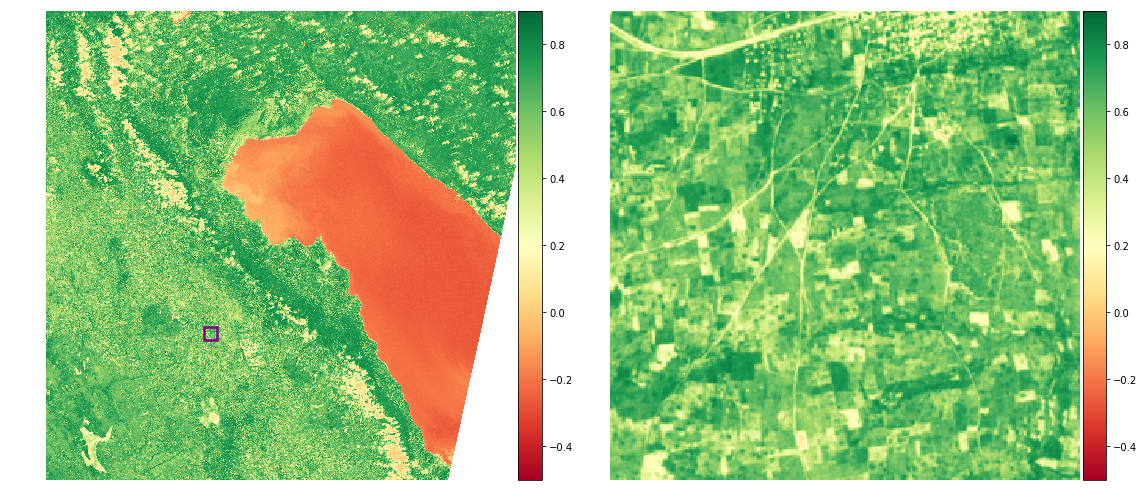

In [20]:
# NDVI for full Sentinel-2 scene
fig, ax = plt.subplots(1, 2, figsize=(16, 16))

# Colormap
cols = 'RdYlGn'

# Full scene
im1 = ax[0].imshow(ds, vmin=-0.5, vmax=0.9, cmap=cols)
divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)
ax[0].axis('off')

# Zoomed in
im2 = ax[1].imshow(ds[7400:7700, 3700:4000], vmin=-0.5, vmax=0.9, cmap=cols)
divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)
ax[1].axis('off')

# Zoomed area rectangle
rect = patches.Rectangle((3700, 7400), 300, 300, linewidth=2.5, edgecolor='purple', 
                         facecolor='none')
ax[0].add_patch(rect)

plt.tight_layout(h_pad=1)

The image on the right is a 300 pixel x 300 pixel (1500 m x 1500 m) zoomed in area of the full Sentinel-2 tile on the left, corresponding to the purple box. At this zoom level, agricultural fields are visible, despite the small field sizes typical of this area. We can also distinguish urban area features including buildings and roads near the top of the zoomed image.

## Step 4 - Create a masked time-series of the NDVI bands for the "cropped" land cover class

For each date in the time-series, we'll create an NDVI "mask", where those pixels that do not overlap with the pixels in the rasterized, ground-truth training data generated in **Step 1** are given a 'no-data' value. First, let's confirm the number of dates in our time series. The `fp` variable points to the directory containing the NDVI GeoTIFFs from **Step 2**:

In [21]:
fp = '/Users/jameysmith/Documents/sentinel2_tanz/aoiTS/geotiffs/ndvi'

# List of file paths to NDVI time-series
files = [fp + '/' + f for f in listdir(fp) if not f.startswith('.')]
files.sort()

print('There were a total of ' + str(len(files)) + ' dates between November 16, 2016 and December 31, 2017 with cloud cover <15%')

There were a total of 28 dates between November 16, 2016 and December 31, 2017 with cloud cover <15%


Let's examine the first few dates in the time-series:

In [22]:
# Grab dates from NDVI file names
dates = [re.findall('\d\d\d\d-\d\d-\d\d', f) for f in files]
dates = [date for sublist in dates for date in sublist]
dates[0:5]

['2016-11-16', '2017-02-14', '2017-04-05', '2017-05-05', '2017-05-15']

As we can see, there are fewer cloud free images earlier in the growing season. The high cloud cover during this period is associated with the unimodal rainy season in Southern Tanzania running from approximately November to April.

Using the `mask_to_array` function from `tsmask`, we can create a 2D numpy array of NDVI values for each date in the time-series, wherein the "mask" (our raster output image from **Step 2**) assigns nodata values to all pixels that to not overlap with the designated land cover class. In our case, we are only interested in the "cropped" land cover class, which has an ID of 3. We therefore assign the `class_num` parameter a value of 3:

In [23]:
crop_mask = tsmask.mask_to_array(files, dates, outimg, class_num=3, gain=0)

The resulting `crop_mask` is a 3D array with 28 "layers" of ndvi values - one for each date in the time-series.

In [24]:
crop_mask.shape

(28, 10980, 10980)

We can convert the resulting numpy array into a `BandTimeSeries` object, which allows for easy manipulation of the 3D numpy array generated above. The object also stores some useful attributes associated with the array including the dates the images were taken, indices in the 2D array that are not no-data values, corresponding to the locations of the labeled "cropped" area within the Sentinel-2 tile.  

In [1]:
cropts = tsmask.BandTimeSeries(mask=crop_mask, lc_class='crop', ts_var='ndvi', dates=dates)

NameError: name 'tsmask' is not defined

We can examine the (row, col) indices of the cropped area pixels within each image. These indiced are the same for all 28 images in the time-series.

In [46]:
cropts.mask_indices()[0:10]

[(5551, 5499),
 (5551, 5500),
 (5551, 5501),
 (5552, 5499),
 (5552, 5500),
 (5552, 5501),
 (5552, 5502),
 (5552, 5503),
 (5552, 5504),
 (5553, 5499)]

Convieniently, the `BandTimeSeries` class contains a `time_series_dataframe` method for extracting an easy to manipulate training dataset in the form of a `Pandas` data frame object. The data frame is out in "long" format wherein each pixel is associated with an NDVI value for each date in the time-series. Each pixel in the "crop" land cover class now has a time-series of NDVI values, which we will use to cluster into natural groups. 

The `time_series_dataframe` method also allows for interpolation of the pixel time-series' into regular intervals. Here, we interpolate to a regular 5-day interval to match the revisit rate of the Sentinel-2 constellation. The `time_series_dataframe` currently only supports simple linear interpolation, although future versions will support alternative interpolation methods and possibly cross-validation methods to select an optimal model.

In [41]:
cropdf = cropts.time_series_dataframe(frequency='5d', interpolate=True)

In [47]:
cropdf.head()

lc  pixel   array_index       date      ndvi
0  crop      0  (5551, 5499) 2016-11-16  0.176800
1  crop      0  (5551, 5499) 2016-11-21  0.200283
2  crop      0  (5551, 5499) 2016-11-26  0.223767
3  crop      0  (5551, 5499) 2016-12-01  0.247250
4  crop      0  (5551, 5499) 2016-12-06  0.270733

## Step 5 - Time-series clustering

Our goal is to cluster these pixels and their NDVI curves (contained in the`cropdf`) into groups that, hopefully, correspond to individual crop types. To perform the clustering, we'll select an unsupervised learning algorithm that relys on Dynamic Time Warping (DTW) to generate the distance matrix between individual NDVI curves. DTW is especially applicable here, as it finds the optimal (non-linear) alignment between two curves, resulting in less pessimistic distance measures between  curves of the same class. This will hopefully allow two curves of the same crop type to be grouped together even if they were planted at different dates, for example. See [this excellent post](http://alexminnaar.com/time-series-classification-and-clustering-with-python.html) for a more detailed examination of the DTW algorithm. 

A drawback of the DTW algorithm is that it's is very computationaly intensive. A fairly complex distance metric needs to be generate for pixel to all other pixels in the dataset. Recall from **Step 1** that the "cropped" area polygons comprised a total of 83,403 pixels. Even in an AWS EC2 with many cores, calculating the distance matrix for all ~83K pixels would be prohibitively slow. We'll therefor create a `TimeSeriesSample` object by selecting a random sample of pixel time-series as shown below (the full analysis involved clustering 10,000 time-series' from the "cropped" land cover class. Th):

In [117]:
cropsamp = tsclust.TimeSeriesSample(cropdf, n_samples=100, ts_var='ndvi', seed=0).smooth()

The `TimeSeriesSample` class also provides a `smooth` method for time-series signal smoothing. Signals derived from satellite imagery are subject to various sources of noise, including atmospheric interference or clouds. It therefore is common to apply a smoother to a time-series to approximate the "true" refelctance signal through time. The `smooth` method currently allows for the application of Savitzky-Golay (Savgol) signal smoothing, wrapping the `savgol_filter`method from `scipy.signal`. The `smooth` method takes a `window` and `poly` parameter to set the window length and polynomial order for `savgol_filter`, respectively. 

The image below illustrates the effect of applying a Savgol filter with the defalut parameters of `window=7` and `poly=3` to 5 random NDVI curves from cropped area pixels. 

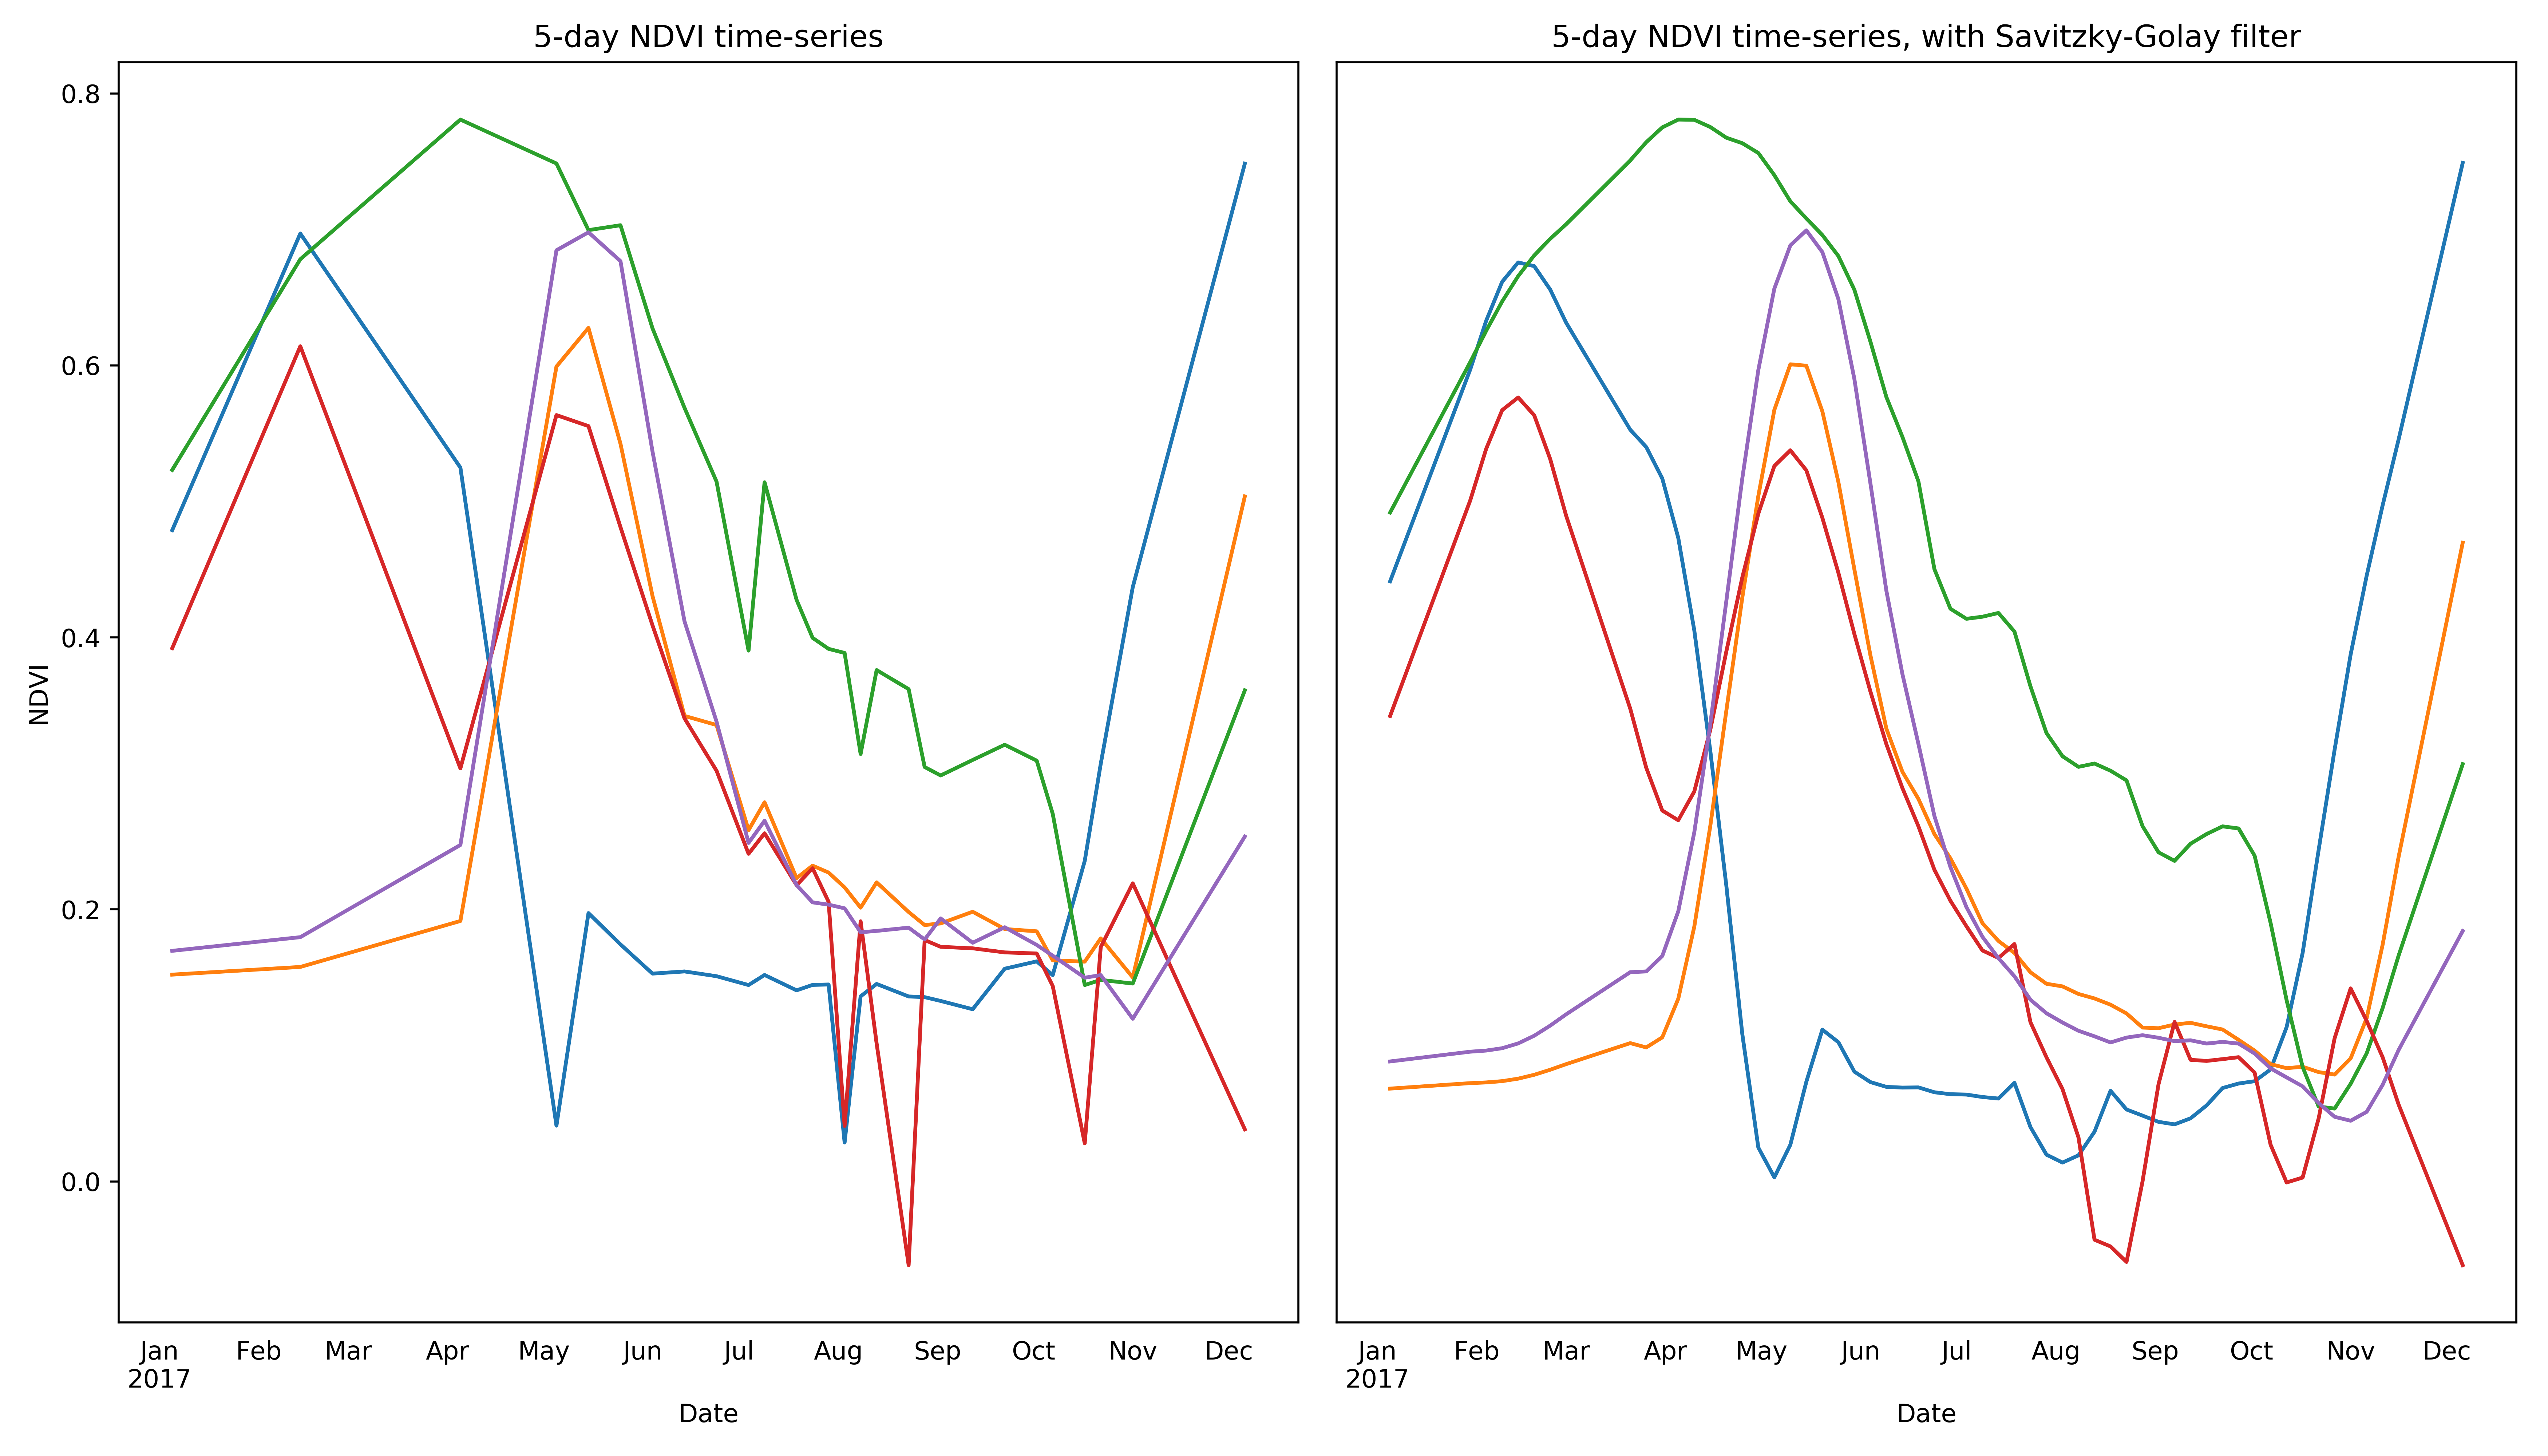

In this example, we'll demonstrate clustering using the smoothed time-series. The `cluster_time_series` function from `tsclust` wraps functionality from the `tslearn` library which provides classes and methods for clustering and classifying time-series', which iteself wraps `scipy`. The following performes clustering of 100 samples using the TimeSeariesKmeans algorithm (with Dynamic Time Warping as the distance metric) provided by the `tslearn` library. The number of clusters can be varied using the `n_clusters` parameter. The `score` parameter can be used to return an average silhouette score (from Scikit-learn) for the clusters - a measurement of the similarity of a given object to its assigned cluster. 

In [98]:
clust_df, score = tsclust.cluster_time_series(ts_sample=cropsamp, cluster_alg='TSKM', 
                                              n_clusters=4, cluster_metric='dtw', score=True)

0.188 --> 0.058 --> 0.054 --> 0.053 --> 0.052 --> 0.052 --> 0.052 --> 0.052 --> 


In [99]:
score

0.3545396168715967

`tsclust` also provides a function, `plot_clusters` for visualizing the results of `cluster_time_series`. For each cluster, the mean value at each time-step is plotted, along with the 10th and 90th percentile values. To display the mean values only, set `fill=False`. 

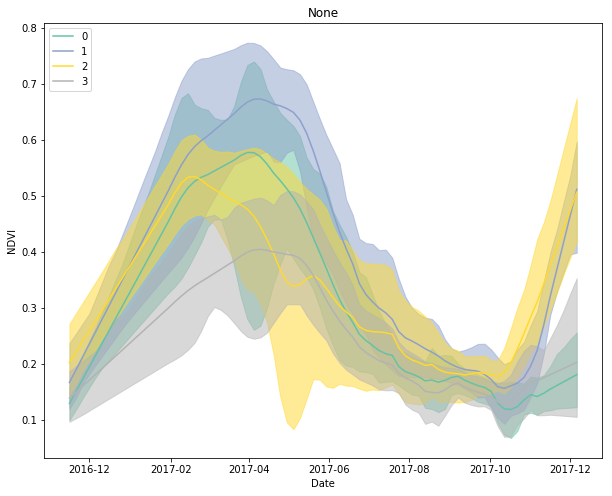

In [102]:
tsclust.plot_clusters(clust_df, fill=True)

Unsupervised learning is a bit of a dark art. There are no "best" metrics for selecting an optimal clustering algorithm, and choosing a set of hyperparameters can be a bit mysterious. The `cluster_grid_search` function from `tsclust` takes a dictionary of hyperparameters (shown below) including the clustering algorithm (time series k-means and global alignment kernel k-means), number of clusters, number of samples, and the metric used to generate distance matrix for clustering (dynamic time warping vs. soft dynamic time warping). Setting `score=True` allows for the various hyperparamter combinations to be evaluated based on their silhouette score.

The following performs a clustering grid-search on 10,000 samples using all hyperparameter combinations included in the `pg` dictionary. The opeartion is extremely computationaly intensive, requiring several days to complete on an extra large EC2 instance. 

In [121]:
# Number of unique pixels (time-series) is 83,403. This is the max 'n_samples' value
pg = {
    'time_seriesdf': [cropsamp],
    'n_samples': [10000],
    'cluster_alg': ['GAKM', 'TSKM'],
    'n_clusters': list(range(2, 8)),
    'smooth': [True],
    'ts_var': ['ndvi'],
    'window': [7],
    'poly': [3],
    'cluster_metric': ['dtw', 'softdtw'],
    'score': [True]
}

In [ ]:
pg_dict, pg_df = tsclust.cluster_grid_search(pg)

The `results` data frame below shows the results of clustering all 10,000 time-series samples. In general, dynamic time warping seemed to perform better than soft dynamic time warping as a distance matrix algorithm, and time series k-means outperformed global alignment kernel k-means as a clustering algorithm, as measured by silhouette score. The performance was similar with between 2 and 5 clusters.

In [4]:
results = pd.read_csv('/Users/jameysmith/Documents/sentinel2_tanz/clustering/cluster_results/smooth_results/gridsearch_results.csv')
results

cluster_alg cluster_metric  n_clusters  score  sil_score
0         GAKM            dtw           2   True   0.253311
1         GAKM        softdtw           2   True   0.220138
2         GAKM            dtw           3   True   0.133689
3         GAKM        softdtw           3   True   0.130685
4         GAKM            dtw           4   True   0.145107
5         GAKM        softdtw           4   True   0.142953
6         GAKM            dtw           5   True   0.133328
7         GAKM        softdtw           5   True   0.155957
8         GAKM            dtw           6   True   0.149439
9         GAKM        softdtw           6   True   0.129197
10        GAKM            dtw           7   True   0.103724
11        GAKM        softdtw           7   True   0.099463
12        GAKM            dtw           8   True   0.102487
13        GAKM        softdtw           8   True   0.097335
14        GAKM            dtw           9   True   0.074727
15        GAKM        softdtw           9   True   0.096421
16        GAKM            dtw          10   True   0.054179
17        GAKM        softdtw          10   True   0.062788
18        TSKM            dtw           2   True   0.358889
19        TSKM        softdtw           2   True   0.245624
20        TSKM            dtw           3   True   0.352203
21        TSKM        softdtw           3   True   0.150963
22        TSKM            dtw           4   True   0.349194
23        TSKM        softdtw           4   True   0.153565
24        TSKM            dtw           5   True   0.334347
25        TSKM        softdtw           5   True   0.129483
26        TSKM            dtw           6   True   0.305330
27        TSKM        softdtw           6   True   0.121057
28        TSKM            dtw           7   True   0.251960
29        TSKM        softdtw           7   True   0.061208
30        TSKM            dtw           8   True   0.240710
31        TSKM        softdtw           8   True   0.081512
32        TSKM            dtw           9   True   0.223699
33        TSKM        softdtw           9   True   0.075730
34        TSKM            dtw          10   True   0.275442
35        TSKM        softdtw          10   True   0.082944

Finally, we can examine a full dataset associated with one of the clustering hyperparameter combinations shown above. The `clust_4` variable below shows the results of clustering 10,000 NDVI curves from the 2017 growing season curves from pixels within agricultural areas in Rukwa Region, Tanzania. Dynamic time warping was used to generated the distance matrix serving as an input to the a time-series k-means clustering algorithm.

In [126]:
clust_4 = pd.read_csv('/Users/jameysmith/Documents/sentinel2_tanz/clustering/cluster_results/smooth_results/final_clusters/4_clusters.csv')

In [127]:
clust_4.head()

lc  pixel   array_index  2016-11-16  2016-11-21  2016-11-26  2016-12-01  \
0  crop      8  (5552, 5504)      0.1336    0.155572    0.177544    0.199517   
1  crop     34  (5555, 5505)      0.0835    0.095661    0.107822    0.119983   
2  crop     48  (5556, 5506)      0.0948    0.104278    0.113756    0.123233   
3  crop     51  (5556, 5509)      0.1023    0.109600    0.116900    0.124200   
4  crop     52  (5556, 5510)      0.1126    0.118300    0.124000    0.129700   

   2016-12-06  2016-12-11  2016-12-16   ...     2017-10-27  2017-11-01  \
0    0.221489    0.243461    0.265433   ...       0.100786    0.115090   
1    0.132144    0.144306    0.156467   ...       0.101120    0.116246   
2    0.132711    0.142189    0.151667   ...       0.103773    0.111533   
3    0.131500    0.138800    0.146100   ...       0.113071    0.125078   
4    0.135400    0.141100    0.146800   ...       0.102627    0.114010   

   2017-11-06  2017-11-11  2017-11-16  2017-11-21  2017-11-26  2017-12-01  \
0    0.148286    0.199071    0.258300    0.311900    0.365500    0.419100   
1    0.140287    0.171373    0.206186    0.238514    0.270843    0.303171   
2    0.133206    0.169313    0.212043    0.250357    0.288671    0.326986   
3    0.144938    0.178576    0.217971    0.253529    0.289086    0.324643   
4    0.142746    0.183792    0.231257    0.274443    0.317629    0.360814   

   2017-12-06  cluster  
0      0.4727        2  
1      0.3355        1  
2      0.3653        1  
3      0.3602        1  
4      0.4040        2  

[5 rows x 82 columns]

Again, we can visualize the mean values of the clusters through time using the `plot_clusters` function. 

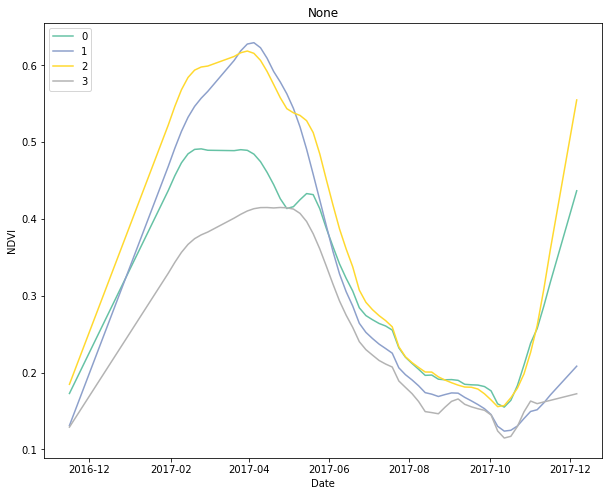

In [132]:
tsclust.plot_clusters(clust_4, fill=False)

We are entering some rather speculative territory now, but it’s possible to compare the above results publicly available [NDVI curves](https://croplands.org/app/data/record?id=2094)from Malawi — a neighboring country in the same agro-ecological zone. As an example, the blue curve in the image above represents a crop planted some time in November, reaching peak growth in May, reaching a maximum NDVI value of around 0.75. Based on the cropping calendar for this region and the overall shape of the curve, there is a good chance that this pixel represents maize.

The next tutorial will focus on building supervised classifiers to predict maize area in Rukwa region by treating the clustered curves shown above as training data. We can, for example, assign clusters 1 and 2 above a label of "maize", train a classifier, and predict the 2017 maize area for the Rukwa region and compare the results with agricultural census data. 